# Download Dataset

In [ ]:
!curl -L -o datasets https://data.mendeley.com/public-files/datasets/w9mr3vf56s/files/1339b6aa-0cb6-4b0d-9b0a-354b947610a2/file_downloaded
!unzip datasets

# Import Library

In [2]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras import layers, models, Model, Input, metrics
from tensorflow.keras.applications import VGG16, EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf

# Konfigurasi Path dan Hyperparameter

In [3]:
# Dataset paths
DATASET_DIR = "/content/Chili Leaf Disease Original Dataset"
FINAL_DIR = "/content/FinalDataset"  # Hanya satu folder final

# Image & Model Params
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 50
LEARNING_RATE = 0.0001
DROPOUT_RATE = 0.3
AUG_PER_IMAGE = 10
NUM_CLASSES = 6
# Split Params
TEST_SIZE = 0.1
VAL_SIZE = 0.2
RANDOM_SEED = 42

# Augmentation Config
AUGMENTATION_CONFIG = dict(
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Split Data

In [4]:
def create_split_folders(base_dir, output_dir, test_size, val_size):
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(output_dir, split), exist_ok=True)

    for class_name in os.listdir(base_dir):
        class_dir = os.path.join(base_dir, class_name)
        if not os.path.isdir(class_dir):
            continue

        images = [os.path.join(class_dir, f) for f in os.listdir(class_dir)
                  if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        if len(images) == 0:
            print(f"⚠️  Tidak ada gambar di {class_name}, dilewati.")
            continue

        random.shuffle(images)

        if len(images) < 5:
            print(f"⚠️  {class_name} punya <5 gambar, semua dijadikan train.")
            train_imgs, val_imgs, test_imgs = images, [], []
        else:
            train_val_imgs, test_imgs = train_test_split(
                images, test_size=test_size, random_state=RANDOM_SEED
            )
            val_ratio_adjusted = val_size / (1 - test_size)
            train_imgs, val_imgs = train_test_split(
                train_val_imgs, test_size=val_ratio_adjusted, random_state=RANDOM_SEED
            )

        for split_name, split_imgs in zip(['train', 'val', 'test'], [train_imgs, val_imgs, test_imgs]):
            split_dir = os.path.join(output_dir, split_name, class_name)
            os.makedirs(split_dir, exist_ok=True)
            for src_path in split_imgs:
                dst_path = os.path.join(split_dir, os.path.basename(src_path))
                shutil.copy(src_path, dst_path)

create_split_folders(DATASET_DIR, FINAL_DIR, TEST_SIZE, VAL_SIZE)
print("\n✅ Dataset dibagi menggunakan train_test_split ke train/val/test.")


✅ Dataset dibagi menggunakan train_test_split ke train/val/test.


# Augmentasi Data

In [5]:
# Augment semua split: train, val, test
splits_to_augment = ['train']

for split_name in splits_to_augment:
    split_dir = os.path.join(FINAL_DIR, split_name)

    print(f"\n🔍 Memulai augmentasi untuk {split_name.upper()} set...")

    datagen = ImageDataGenerator(**AUGMENTATION_CONFIG)

    for class_name in os.listdir(split_dir):
        class_path = os.path.join(split_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        save_path = class_path  # Augment in-place

        images = [f for f in os.listdir(class_path)
                  if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        if len(images) == 0:
            print(f"⚠️  Folder {class_name} kosong, dilewati.")
            continue

        for img_name in tqdm(images, desc=f"Augmenting {split_name}/{class_name}"):
            img_path = os.path.join(class_path, img_name)
            try:
                img = load_img(img_path, target_size=IMAGE_SIZE)
                x = img_to_array(img)
                x = x.reshape((1,) + x.shape)

                i = 0
                for batch in datagen.flow(
                    x, batch_size=1, save_to_dir=save_path,
                    save_prefix=os.path.splitext(img_name)[0], save_format="jpg"
                ):
                    i += 1
                    if i >= AUG_PER_IMAGE:
                        break
            except Exception as e:
                print(f"❌ Gagal augmentasi {img_name}: {e}")

print("\n✅ Augmentasi selesai untuk semua set (train, val, test).")


🔍 Memulai augmentasi untuk TRAIN set...


Augmenting train/Cercospora Leaf Spot: 100%|██████████| 126/126 [00:28<00:00,  4.50it/s]


✅ Augmentasi selesai untuk semua set (train, val, test).


# Pembuatan data Genetor

In [6]:
data_gen = ImageDataGenerator(rescale=1./255)

train_ds = data_gen.flow_from_directory(
    os.path.join(FINAL_DIR, "train"),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = data_gen.flow_from_directory(
    os.path.join(FINAL_DIR, "val"),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

test_ds = data_gen.flow_from_directory(
    os.path.join(FINAL_DIR, "test"),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 14233 images belonging to 6 classes.
Found 373 images belonging to 6 classes.
Found 188 images belonging to 6 classes.


# Definisi CBAM Block

In [7]:
@register_keras_serializable()
class MCDropout(layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

    def get_config(self):
        return super().get_config()

def channel_attention_module(x, ratio=8):
    """
    Implementasi Channel Attention Module (Sesuai Figure 6 Paper - Atas)
    """
    # Menentukan axis channel secara dinamis
    channel_axis = 1 if tf.keras.backend.image_data_format() == "channels_first" else -1
    channel = x.shape[channel_axis]

    # Shared MLP layers
    shared_layer_one = layers.Dense(channel // ratio,
                                    activation='relu',
                                    kernel_initializer='he_normal',
                                    use_bias=True,
                                    bias_initializer='zeros')
    shared_layer_two = layers.Dense(channel,
                                    kernel_initializer='he_normal',
                                    use_bias=True,
                                    bias_initializer='zeros')

    # 1. Global Average Pooling Path
    avg_pool = layers.GlobalAveragePooling2D()(x)
    avg_pool = layers.Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    # 2. Global Max Pooling Path
    max_pool = layers.GlobalMaxPooling2D()(x)
    max_pool = layers.Reshape((1, 1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    # 3. Add & Sigmoid
    cbam_feature = layers.Add()([avg_pool, max_pool])
    cbam_feature = layers.Activation('sigmoid')(cbam_feature)

    # 4. Multiply
    return layers.Multiply()([x, cbam_feature])

def spatial_attention_module(x):
    """
    Implementasi Spatial Attention Module (Sesuai Figure 6 Paper - Bawah)
    PERBAIKAN: Menggunakan Lambda Layer untuk operasi tf.reduce_mean/max
    agar kompatibel dengan Keras Functional API.
    """
    # 1. Channel Pooling (Max & Avg) sepanjang axis channel
    # Axis -1 diasumsikan channels_last (standar Colab/TF)

    # Bungkus tf.reduce_mean dengan Lambda
    avg_pool = layers.Lambda(lambda t: tf.reduce_mean(t, axis=-1, keepdims=True),
                             name='spatial_avg_pool')(x)

    # Bungkus tf.reduce_max dengan Lambda
    max_pool = layers.Lambda(lambda t: tf.reduce_max(t, axis=-1, keepdims=True),
                             name='spatial_max_pool')(x)

    # 2. Concatenate
    concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])

    # 3. Convolution 7x7 + Sigmoid
    cbam_feature = layers.Conv2D(filters=1,
                                 kernel_size=7,
                                 strides=1,
                                 padding='same',
                                 activation='sigmoid',
                                 kernel_initializer='he_normal',
                                 use_bias=False)(concat)

    # 4. Multiply
    return layers.Multiply()([x, cbam_feature])

def cbam_block(x):
    """
    Menggabungkan Channel dan Spatial Attention secara sekuensial.
    """
    x = channel_attention_module(x)
    x = spatial_attention_module(x)
    return x

# Compile Model Hybrid (VGG16 + EfficientNetB0 + CBAM)

In [ ]:
def build_vgg_effattnnet():
    # Input Layer
    input_tensor = Input(shape=(*IMAGE_SIZE, 3), name="input_image")

    # ---------------------------------------------------------
    # BRANCH 1: Fine-Tuned VGG16
    # ---------------------------------------------------------
    vgg_base = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

    for layer in vgg_base.layers[:-4]:
        layer.trainable = False
    for layer in vgg_base.layers[-4:]:
        layer.trainable = True

    for layer in vgg_base.layers:
        layer._name = "vgg_" + layer.name

    vgg_out = vgg_base.output
    vgg_flat = layers.Flatten(name='vgg_flatten')(vgg_out)

    vgg_dense = layers.Dense(256, activation='relu', name='vgg_dense')(vgg_flat)
    vgg_branch = MCDropout(DROPOUT_RATE, name='vgg_mcd')(vgg_dense)

    # ---------------------------------------------------------
    # BRANCH 2: EfficientNetB0 + CBAM
    # ---------------------------------------------------------
    eff_base = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=input_tensor)

    for layer in eff_base.layers[:-20]:
        layer.trainable = False
    for layer in eff_base.layers[-20:]:
        layer.trainable = True

    for layer in eff_base.layers:
        layer._name = "eff_" + layer.name

    # Ambil Output Feature Map
    eff_features = eff_base.output

    # --- PENERAPAN ATTENTION (Revised) ---
    eff_attn_features = cbam_block(eff_features)

    # Skip Connection
    eff_refined = layers.Add(name='eff_skip_connection')([eff_features, eff_attn_features])

    # Global Average Pooling
    eff_gap = layers.GlobalAveragePooling2D(name='eff_gap')(eff_refined)

    # MC Dropout
    eff_branch = MCDropout(DROPOUT_RATE, name='eff_mcd')(eff_gap)

    # ---------------------------------------------------------
    # FUSION & CLASSIFICATION
    # ---------------------------------------------------------
    merged = layers.Concatenate(name='feature_fusion')([vgg_branch, eff_branch])

    x = layers.Dense(256, activation='relu', name='fusion_dense')(merged)
    x = MCDropout(DROPOUT_RATE, name='fusion_mcd')(x)

    output = layers.Dense(NUM_CLASSES, activation='softmax', name='classification_output')(x)

    model = models.Model(inputs=input_tensor, outputs=output, name="VGG-EffAttnNet_Corrected")
    return model

# Build & Summary
model = build_vgg_effattnnet()
model.summary()

# Compile Model
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')]
)

# Training Model dengan Callbacks



In [9]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint('vgg_effattnnet_best.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
]

print("\n🚀 Starting Training...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)


🚀 Starting Training...
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.7496 - loss: 0.6571 - precision: 0.8745 - recall: 0.6628
Epoch 1: val_accuracy improved from -inf to 0.97319, saving model to vgg_effattnnet_best.keras
890/890 ━━━━━━━━━━━━━━━━━━━━ 225s 203ms/step - accuracy: 0.7498 - loss: 0.6568 - precision: 0.8746 - recall: 0.6630 - val_accuracy: 0.9732 - val_loss: 0.0804 - val_precision: 0.9758 - val_recall: 0.9732
Epoch 2/50
890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9753 - loss: 0.0779 - precision: 0.9780 - recall: 0.9733
Epoch 2: val_accuracy improved from 0.97319 to 0.97587, saving model to vgg_effattnnet_best.keras
890/890 ━━━━━━━━━━━━━━━━━━━━ 132s 148ms/step - accuracy: 0.9753 - loss: 0.0779 - precision: 0.9780 - recall: 0.9733 - val_accuracy: 0.9759 - val_loss: 0.0724 - val_precision: 0.9784 - val_recall: 0.9732
Epoch 3/50
890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9860 - loss: 0.0480 - precision: 0.9866 - recall: 0.9843
Epoch 3: val_accuracy improved from 0

# Visualisasi Hasil Training

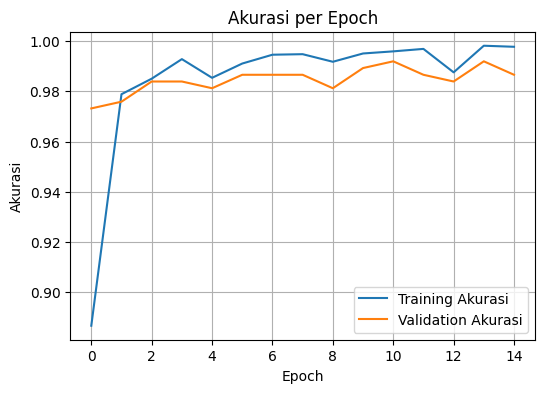

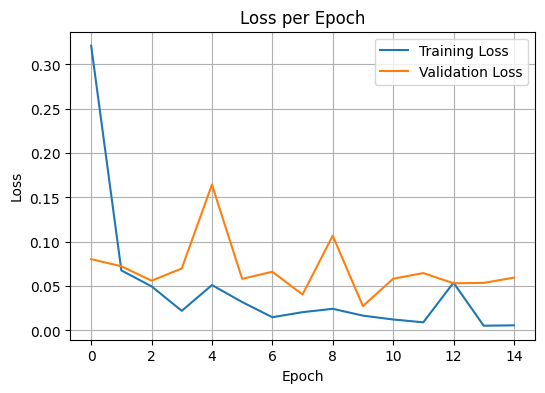

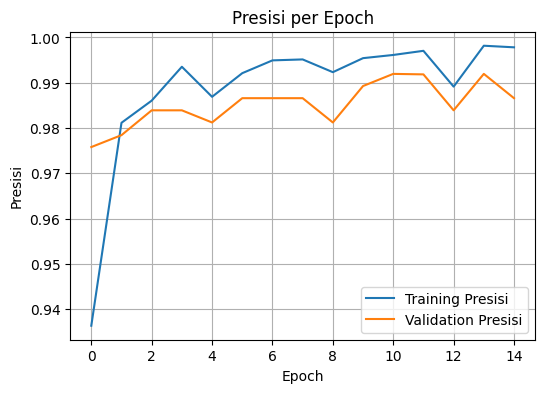

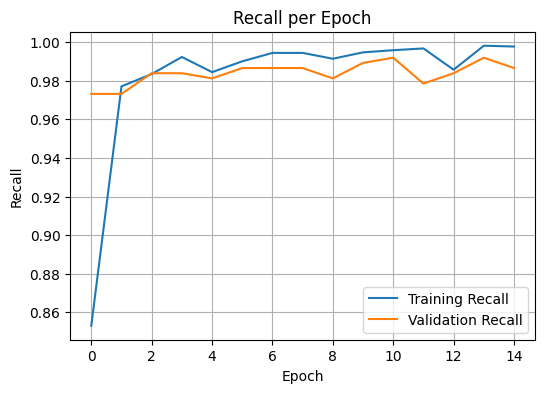

In [10]:
def plot_training(history):
    # Pastikan hanya metrik yang tersedia di history yang diplot
    available_metrics = list(history.history.keys())
    metrics_to_plot = [
        ('accuracy', 'Akurasi'),
        ('loss', 'Loss'),
        ('precision', 'Presisi'),
        ('recall', 'Recall')
    ]

    for m, label in metrics_to_plot:
        train_key, val_key = m, f'val_{m}'
        if train_key in available_metrics and val_key in available_metrics:
            plt.figure(figsize=(6, 4))
            plt.plot(history.history[train_key], label=f'Training {label}')
            plt.plot(history.history[val_key], label=f'Validation {label}')
            plt.title(f'{label} per Epoch')
            plt.xlabel('Epoch')
            plt.ylabel(label)
            plt.legend()
            plt.grid(True)
            plt.show()
        else:
            print(f"⚠️ Metrik '{m}' tidak tersedia di history, dilewati.")

plot_training(history)

# Evaluasi Model dan Analisis Waktu Inferensi


COMPREHENSIVE MODEL EVALUATION
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step

📊 CLASSIFICATION REPORT:
                      precision    recall  f1-score   support

      Bacterial Spot     0.9333    0.8750    0.9032        16
Cercospora Leaf Spot     0.8889    0.8889    0.8889        18
          Curl Virus     0.9773    1.0000    0.9885        43
        Healthy Leaf     1.0000    0.9783    0.9890        46
Nutrition Deficiency     0.9783    1.0000    0.9890        45
          White spot     1.0000    1.0000    1.0000        20

            accuracy                         0.9734       188
           macro avg     0.9630    0.9570    0.9598       188
        weighted avg     0.9733    0.9734    0.9732       188



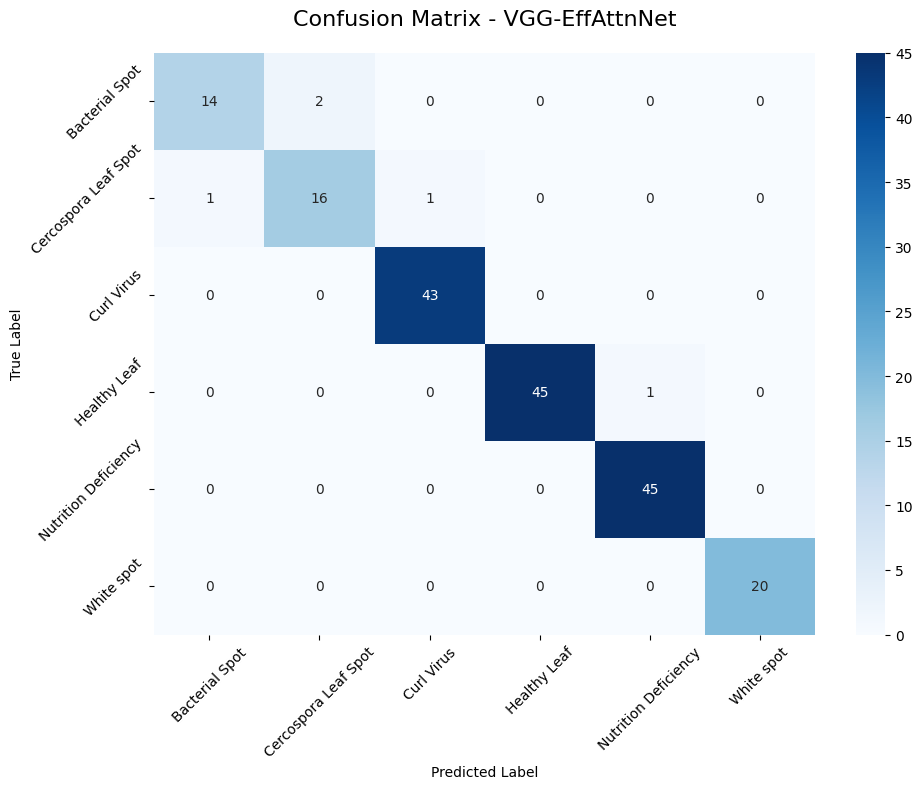


🎯 KEY METRICS:
Accuracy:  0.9734
Precision: 0.9733
Recall:    0.9734
F1-Score:  0.9732


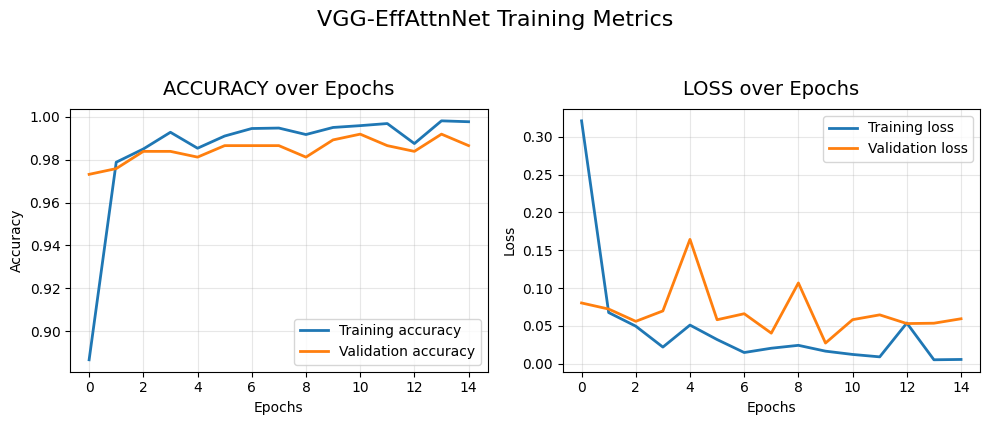

In [11]:
from sklearn.model_selection import KFold
import time
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

def comprehensive_evaluation(model, test_generator, history=None):
    """Evaluasi komprehensif sesuai paper section 6"""

    print("\n" + "="*60)
    print("COMPREHENSIVE MODEL EVALUATION")
    print("="*60)

    # Reset generator
    test_generator.reset()

    # Predictions
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_generator.classes

    # 1. Classification Report
    print("\n📊 CLASSIFICATION REPORT:")
    print(classification_report(y_true, y_pred_classes,
                              target_names=list(test_generator.class_indices.keys()), digits=4))

    # 2. Confusion Matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_generator.class_indices.keys(),
                yticklabels=test_generator.class_indices.keys())
    plt.title('Confusion Matrix - VGG-EffAttnNet', fontsize=16, pad=20)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 3. Calculate additional metrics
    accuracy = np.mean(y_true == y_pred_classes)

    # Calculate precision, recall, F1 manually
    precision = precision_score(y_true, y_pred_classes, average='weighted')
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    f1 = f1_score(y_true, y_pred_classes, average='weighted')

    print(f"\n🎯 KEY METRICS:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")

    # 4. Training History Visualization
    if history is not None:
        plot_comprehensive_training(history)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm
    }

def plot_comprehensive_training(history):
    """Plot training history lengkap sesuai paper"""

    metrics = ['accuracy', 'loss']
    # Cek metrik mana yang tersedia
    available_metrics = [m for m in metrics if m in history.history]

    fig, axes = plt.subplots(1, len(available_metrics), figsize=(5*len(available_metrics), 4))
    if len(available_metrics) == 1:
        axes = [axes]

    for i, metric in enumerate(available_metrics):
        axes[i].plot(history.history[metric], label=f'Training {metric}', linewidth=2)
        if f'val_{metric}' in history.history:
            axes[i].plot(history.history[f'val_{metric}'],
                       label=f'Validation {metric}', linewidth=2)

        axes[i].set_title(f'{metric.upper()} over Epochs', fontsize=14, pad=10)
        axes[i].set_xlabel('Epochs')
        axes[i].set_ylabel(metric.capitalize())
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)

    plt.suptitle('VGG-EffAttnNet Training Metrics', fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()

def analyze_inference_time(model, test_generator, num_runs=3):
    """Analisis inference time sesuai paper Table 4"""

    print("\n⏱️ INFERENCE TIME ANALYSIS")

    # Warm-up run
    test_generator.reset()
    _ = model.predict(test_generator, verbose=0)

    # Actual measurement
    inference_times = []
    n_images = len(test_generator.filenames)

    for run in range(num_runs):
        test_generator.reset()
        start_time = time.time()

        _ = model.predict(test_generator, verbose=0)

        end_time = time.time()
        inference_time = end_time - start_time
        inference_times.append(inference_time)

    avg_inference_time = np.mean(inference_times)
    avg_time_per_image = avg_inference_time / n_images * 1000  # ms per image
    avg_fps = n_images / avg_inference_time

    print(f"📊 INFERENCE PERFORMANCE:")
    print(f"Total time for {n_images} images: {avg_inference_time:.2f}s")
    print(f"Time per image: {avg_time_per_image:.2f}ms")
    print(f"Frames per second: {avg_fps:.1f} FPS")

    return {
        'total_time': avg_inference_time,
        'time_per_image': avg_time_per_image,
        'fps': avg_fps
    }

# PANGGIL FUNGSI EVALUASI SETELAH TRAINING

# 1. Evaluasi komprehensif
eval_results = comprehensive_evaluation(model, test_ds, history)


In [12]:
# 2. Analisis inference time
inference_results = analyze_inference_time(model, test_ds)

# 3. Tampilkan summary
print("\n" + "="*60)
print("🎯 FINAL TRAINING RESULTS")
print("="*60)
print(f"📈 Accuracy: {eval_results['accuracy']:.4f} ({eval_results['accuracy']*100:.2f}%)")
print(f"🎯 Precision: {eval_results['precision']:.4f}")
print(f"🎯 Recall: {eval_results['recall']:.4f}")
print(f"🎯 F1-Score: {eval_results['f1_score']:.4f}")
print(f"⏱️ Inference Time: {inference_results['time_per_image']:.2f}ms per image")
print(f"⚡ Inference Speed: {inference_results['fps']:.1f} FPS")
print("="*60)


⏱️ INFERENCE TIME ANALYSIS
📊 INFERENCE PERFORMANCE:
Total time for 188 images: 2.19s
Time per image: 11.63ms
Frames per second: 86.0 FPS

🎯 FINAL TRAINING RESULTS
📈 Accuracy: 0.9734 (97.34%)
🎯 Precision: 0.9733
🎯 Recall: 0.9734
🎯 F1-Score: 0.9732
⏱️ Inference Time: 11.63ms per image
⚡ Inference Speed: 86.0 FPS


# Penyimpanan Model .keras

In [13]:
print("\n💾 Saving Model...")
model.save("final_vgg_effattnnet.keras")

print("\n🔄 Verifying Model Loading...")


💾 Saving Model...

🔄 Verifying Model Loading...


# Testing Sederhana dengan Model yang Dimuat


🔄 1. Membangun ulang arsitektur & memuat bobot...
   ✅ Model Siap!

📂 2. Menyiapkan Data Test...
Found 188 images belonging to 6 classes.

🧪 3. Visual Testing...


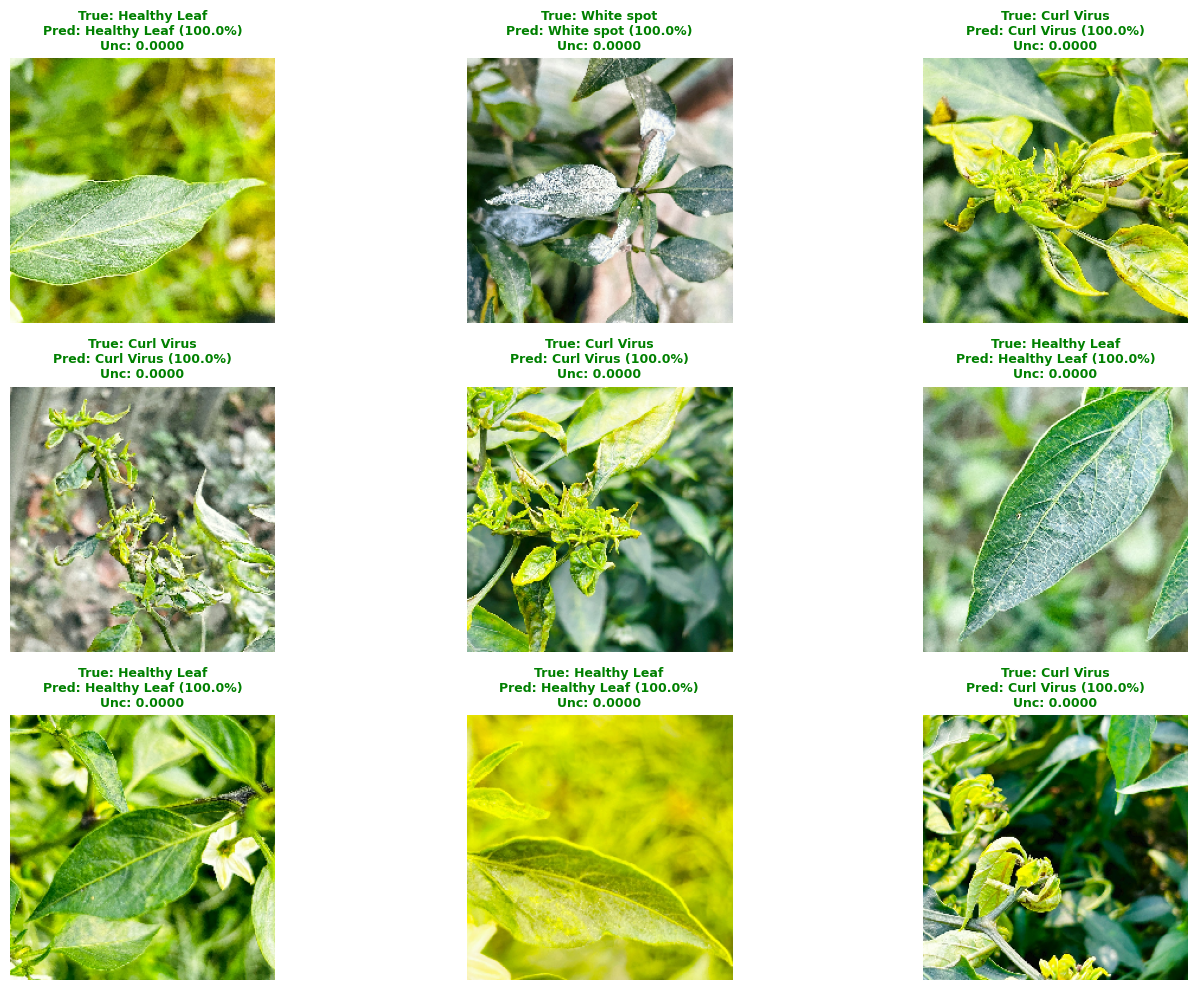


📊 4. Laporan Evaluasi Akhir...
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 788ms/step - accuracy: 0.9325 - loss: 0.9203 - precision: 0.9325 - recall: 0.9325

📈 HASIL AKHIR
📉 Loss      : 0.3467
✅ Accuracy  : 96.81%
🎯 Precision : 0.9681
🔄 Recall    : 0.9681
⚖️  F1-Score  : 0.9681

ℹ️ CATATAN TENTANG AKURASI:
Karena menggunakan MC Dropout, hasil akan sedikit bervariasi (±1-2%)


In [25]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.metrics as metrics

# ==========================================
# KONFIGURASI
# ==========================================
MODEL_PATH = "final_vgg_effattnnet.keras"
DATASET_DIR = "/content/FinalDataset"
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

# ==========================================
# 1. LOAD MODEL (RE-BUILD & LOAD WEIGHTS)
# ==========================================
print("\n🔄 1. Membangun ulang arsitektur & memuat bobot...")
try:
    # Pastikan fungsi build_vgg_effattnnet() sudah didefinisikan di cell sebelumnya
    model = build_vgg_effattnnet()
    model.load_weights(MODEL_PATH)

    # Compile ulang
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')]
    )
    print("   ✅ Model Siap!")
except Exception as e:
    print(f"   ❌ Error Loading: {e}")
    model = None

# ==========================================
# 2. LOAD DATA TEST
# ==========================================
print("\n📂 2. Menyiapkan Data Test...")
test_dir = os.path.join(DATASET_DIR, "test")
if os.path.exists(test_dir) and model:
    test_gen = ImageDataGenerator(rescale=1./255)
    test_ds = test_gen.flow_from_directory(
        test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
        class_mode='categorical', shuffle=False
    )
    class_names = list(test_ds.class_indices.keys())
else:
    print("   ❌ Dataset atau Model tidak siap.")
    test_ds = None

# ==========================================
# 3. FUNGSI MC DROPOUT (YANG DIPERBAIKI)
# ==========================================
def predict_mc(model, img_tensor, n_iter=10):
    # Replikasi input menjadi batch (n_iter, 224, 224, 3)
    tiled = tf.tile(img_tensor, [n_iter, 1, 1, 1])

    # Prediksi (Training=False, karena MCDropout layer aktif sendiri)
    preds = model(tiled, training=False)

    # Hitung Mean & Std Dev (Uncertainty)
    # FIX: Hapus [0] agar mengembalikan array probabilitas (shape: 6,)
    mean_pred = tf.reduce_mean(preds, axis=0).numpy()
    uncertainty = tf.reduce_mean(tf.math.reduce_std(preds, axis=0)).numpy()

    return mean_pred, uncertainty

# ==========================================
# 4. VISUAL TESTING
# ==========================================
if model and test_ds:
    print("\n🧪 3. Visual Testing...")
    samples = random.sample(test_ds.filepaths, min(len(test_ds.filepaths), 9))

    plt.figure(figsize=(15, 10))
    for i, path in enumerate(samples):
        try:
            img = image.load_img(path, target_size=IMG_SIZE)
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0) / 255.0

            # Prediksi
            probs, unc = predict_mc(model, x)

            idx = np.argmax(probs)
            label_pred = class_names[idx]
            label_true = os.path.basename(os.path.dirname(path))
            conf = probs[idx]

            # Plot
            plt.subplot(3, 3, i+1)
            plt.imshow(img)
            col = 'green' if label_pred == label_true else 'red'
            plt.title(f"True: {label_true}\nPred: {label_pred} ({conf:.1%})\nUnc: {unc:.4f}",
                      color=col, fontsize=9, fontweight='bold')
            plt.axis('off')
        except Exception as e:
            print(f"Err: {e}")
    plt.tight_layout()
    plt.show()

# ==========================================
# 5. EVALUASI METRIK
# ==========================================
if model and test_ds:
    print("\n📊 4. Laporan Evaluasi Akhir...")
    test_ds.reset()

    # Jalankan evaluasi
    results = model.evaluate(test_ds, verbose=1)

    if len(results) >= 4:
        loss = results[0]
        acc = results[1]
        prec = results[2]
        rec = results[3]
    else:
        # Fallback jika jumlah metric beda
        print(f"⚠️ Warning: Jumlah output metric tidak standar ({len(results)} output).")
        loss, acc = results[0], results[1]
        prec, rec = 0, 0

    print("\n" + "="*30)
    print("📈 HASIL AKHIR")
    print("="*30)
    print(f"📉 Loss      : {loss:.4f}")
    print(f"✅ Accuracy  : {acc:.2%}")
    print(f"🎯 Precision : {prec:.4f}")
    print(f"🔄 Recall    : {rec:.4f}")

    # Hitung F1 Score Manual
    if (prec + rec) > 0:
        f1 = 2 * (prec * rec) / (prec + rec)
        print(f"⚖️  F1-Score  : {f1:.4f}")
    print("="*30)

    print("\nℹ️ CATATAN TENTANG AKURASI:")
    print("Karena menggunakan MC Dropout, hasil akan sedikit bervariasi (±1-2%)")

# Miscellanious


In [19]:
import os
import json

dataset_train_path = "/content/FinalDataset/train"

if os.path.exists(dataset_train_path):
    # Keras flow_from_directory mengurutkan label secara ALFABETIS
    class_names = sorted([
        d for d in os.listdir(dataset_train_path)
        if os.path.isdir(os.path.join(dataset_train_path, d))
    ])

    print("Urutan Kelas yang Ditemukan:")
    print(class_names)

    # Simpan ke file JSON
    with open("class_names.json", "w") as f:
        json.dump(class_names, f)

    print("\n✅ Berhasil menyimpan 'class_names.json'. Silakan download file ini.")
else:
    print("❌ Folder dataset tidak ditemukan. Pastikan path benar.")

Urutan Kelas yang Ditemukan:
['Bacterial Spot', 'Cercospora Leaf Spot', 'Curl Virus', 'Healthy Leaf', 'Nutrition Deficiency', 'White spot']

✅ Berhasil menyimpan 'class_names.json'. Silakan download file ini.
